In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import scipy.odr as odr
from typing import Optional
from datetime import datetime

In [2]:
# Plot parameters

data_path = "data"
res_path = "res"

# Generate Figure S1

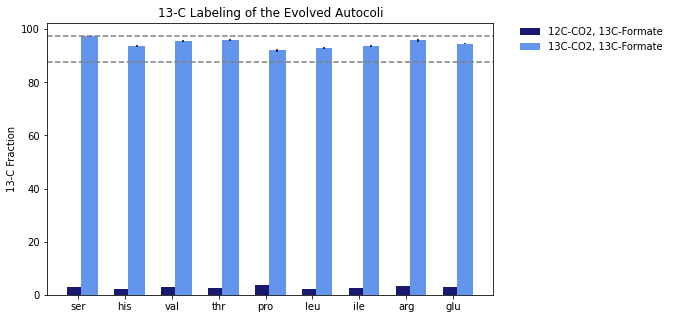

In [3]:
#insert here the file name and path

experiment_name = "DataS2-compact_evolved_Labeling_run_curated_peaks_summary"
plot_name = "figureS1_labeling"

orig_file = f"{data_path}/{experiment_name}.xlsx"
dest_file = f"{res_path}/{plot_name}.svg"

strain_name = "Evolved Autocoli"

data = pd.read_excel(orig_file)
#taking only the first 12 rows that are relevant for plot:
data = data.iloc[1:10]

#subsetting for relevant cols for 83 (compact Autocoli):
col_names = data.columns[data.columns.str.find("66") == 0].tolist()
df_66 = data[col_names]

#taking aa names for x axis
amino_acids = data.iloc[:,0].tolist()
#taking col of 13FOR and the mean of 3 rep. of 13CO2 of both exp. into same list:
CO2_13 = df_66.iloc[:,0:3].mean(axis=1)*100
FOR_13 = df_66.iloc[:,3]*100
#taking cols for error bars:
Error = df_66.iloc[:,0:3].std(axis=1)*100

X = np.arange(9)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
ax.bar(X + 0.00, FOR_13.tolist(), color = 'midnightblue', width = 0.45)
ax.bar(X + 0.25, CO2_13.tolist(), color = 'cornflowerblue', width = 0.35, yerr=Error )
ax.set_xticks(X)
ax.set_xticklabels(amino_acids)
ax.legend(labels=['12C-CO2, 13C-Formate', '13C-CO2, 13C-Formate'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
ax.set_ylabel('13-C Fraction')
csfont = {'fontname':'fantasy'}
ax.set_title('13-C Labeling of the {}'.format(strain_name))
ax.axhline(y = 87.5, color = 'grey', linestyle = 'dashed')
ax.axhline(y = 97.625, color = 'grey', linestyle = 'dashed')
plt.rcParams["font.family"] = 'Arial'
    
plt.savefig(dest_file)

# Generate Figure S2

In [4]:
experiment_name1 = "DataS15-Compact_AutoColi_dasgib_log"
experiment_name2 = "DataS16-Scaffoldless_Autocoli_dasgib_log"

orig_file1 = f"{data_path}/{experiment_name1}.csv"
orig_file2 = f"{data_path}/{experiment_name2}.csv"

dest_file = f"{res_path}/figure_S2/figureS2_"

In [8]:
# defining functions to calculate time window, OD600, growth rates and plotting

def find_max_growth_rate(
    file_name: str,
    OD_column: int,
    strain: str,
    rep: str,
    color: str,
    title: str,
    start: int,
    end: int,
    calculated_initial_OD: Optional[float] = None,
) -> plt.Figure:
    """
        Arguments:
        file_name: str
            the name of the CSV file containing the raw data

        unit: int
            the bacteriology unit (either 1 or 3)

        title:
            the title of the experiment

        start: int 
            the start time of the growth curve you want to plot,
            in number of samples (#row in the table)

        end: int
            the end time of the growth curve you want to plot,
            in number of samples (#row in the table)
            
        calculate_initial_OD: float
            the OD600 that the experimentalist uses to innoculate the culture
    """
    data = pd.read_csv(file_name)
    
    # measured data and actual OD600
    df = select_OD_window(data=data, OD_column=OD_column, calculated_initial_OD=calculated_initial_OD, start=start, end=end)
    
    # claulate growth rates and plotting
    od = calc_growth_rate(df, winlength=30, gr_winlength=70)
    
    max_GR.loc[rep,strain] = od.growth_rate.max()
    max_OD.loc[rep,strain] = od.smooth_OD.max()
    
    # plot the growth curves
    return plot_growth_rate(od, color=color, title=title) 


def select_OD_window(
    data: pd.DataFrame,
    OD_column: str,
    calculated_initial_OD: Optional[float] = None,
    start: int = 0,
    end: Optional[int] = None,
) -> pd.DataFrame:
       
    if not start:
        start = 0
    if not end:
        end = data.shape[0]
    data = data.loc[start:end,].copy()
    data['AU'] = data[OD_column]*2.7031 + 0.0075 # transformation from internal valuse to OD600
    if calculated_initial_OD is not None: # normalize the data so that the OD at t=0 is the calculated value
        data['AU'] += calculated_initial_OD - data['AU'].iat[0]

    data["Timestamp"] = pd.to_datetime(data.Timestamp, format="%m/%d/%y %H:%M:%S")
    data["time_in_hours"] = (data.Timestamp - data.Timestamp.iat[0]).apply(lambda x: x.total_seconds()) / 3600.0
    return data


def calc_growth_rate(
    data: pd.DataFrame,
    winlength: int,
    gr_winlength: int,
) -> pd.DataFrame:
    
    def calc_slope(x):
        lin = lambda B,x: B[0]*x+B[1]
        fit = odr.ODR(data=odr.Data(x.index, x.values),model=odr.Model(lin), beta0=[0.,0.]).run()
        return fit.beta[0]
    
    od_ts = data.loc[~data['InoculationTime []'].isna(), :].set_index("time_in_hours")  
    od_ts["smooth_OD"] = od_ts.AU.dropna().rolling(window=winlength, center=True).mean()
    od_ts["log2_OD"] = np.log2(od_ts.smooth_OD)
    od_ts["growth_rate"] = od_ts.log2_OD.dropna().rolling(window=gr_winlength, center=True).apply(calc_slope, raw=False)
    return od_ts


def plot_growth_rate(
    od_ts_smooth: pd.DataFrame,
    title: str,
    color: str,
) -> plt.Figure:
    
    max_growth_rate = od_ts_smooth.growth_rate.max()
    max_OD = od_ts_smooth.smooth_OD.max()
    
    fig, axs = plt.subplots(3, 1, figsize=(4, 8), sharex=True, dpi=150)
    axs[0].plot(od_ts_smooth.index, od_ts_smooth.smooth_OD, label="smoothed", color=color)
    axs[1].plot(od_ts_smooth.index, od_ts_smooth.log2_OD, color=color)
    axs[2].plot(od_ts_smooth.index, od_ts_smooth.growth_rate, color=color)
    axs[0].set_ylabel('OD600')
    axs[0].set_ylim(0,0.38)
    axs[1].set_ylabel('log2(OD)')
    axs[1].set_ylim(-5,-1)
    axs[2].set_ylabel('growth rate [h$^{-1}$]')
    axs[2].set_xlabel('Time [h]')
    axs[2].set_ylim(0,0.07)
    axs[0].set_title(title)
    axs[1].set_title(f"Max $OD_{{600}}$  = {max_OD:.2f}")
    axs[2].set_title(f"$\\mu_{{max}}$ = {max_growth_rate:.3f} 1/h")
    
    # changing parameters of plotting for plot of all reps (per strain)
    if color == 'darkseagreen':
        fig.set_size_inches(10,10)
        axs[0].set_xlim(left=0)
        indices = [2999, 3999, 4499, 5249, 7499, 8476]
        for index in indices:
            axs[0].axvline(x=od_ts_smooth.index[index], color='grey', linestyle=':', linewidth = 1)
        for itr, element in enumerate(indices[::2]):
            axs[0].text(x=(od_ts_smooth.index[element]+100), y=0.3, s=f'rep {itr+1}', fontsize=15, color='grey')         
    if color == 'steelblue':
        axs[0].set_xlim(0,od_ts_smooth.index[8850])
        fig.set_size_inches(10,10)
        indices = [5595, 6149, 7031, 7628, 7631, 8604]
        for index in indices:
            axs[0].axvline(x=od_ts_smooth.index[index], color='grey', linestyle=':', linewidth = 1)
        for itr, element in enumerate(indices[::2]):
            axs[0].text(x=(od_ts_smooth.index[element]+100), y=0.3, s=f'rep {itr+1}', fontsize=15, color='grey')         
    return fig

#data frames for saving growth parameters
max_GR = pd.DataFrame()
max_OD = pd.DataFrame()

### Plotting panel A

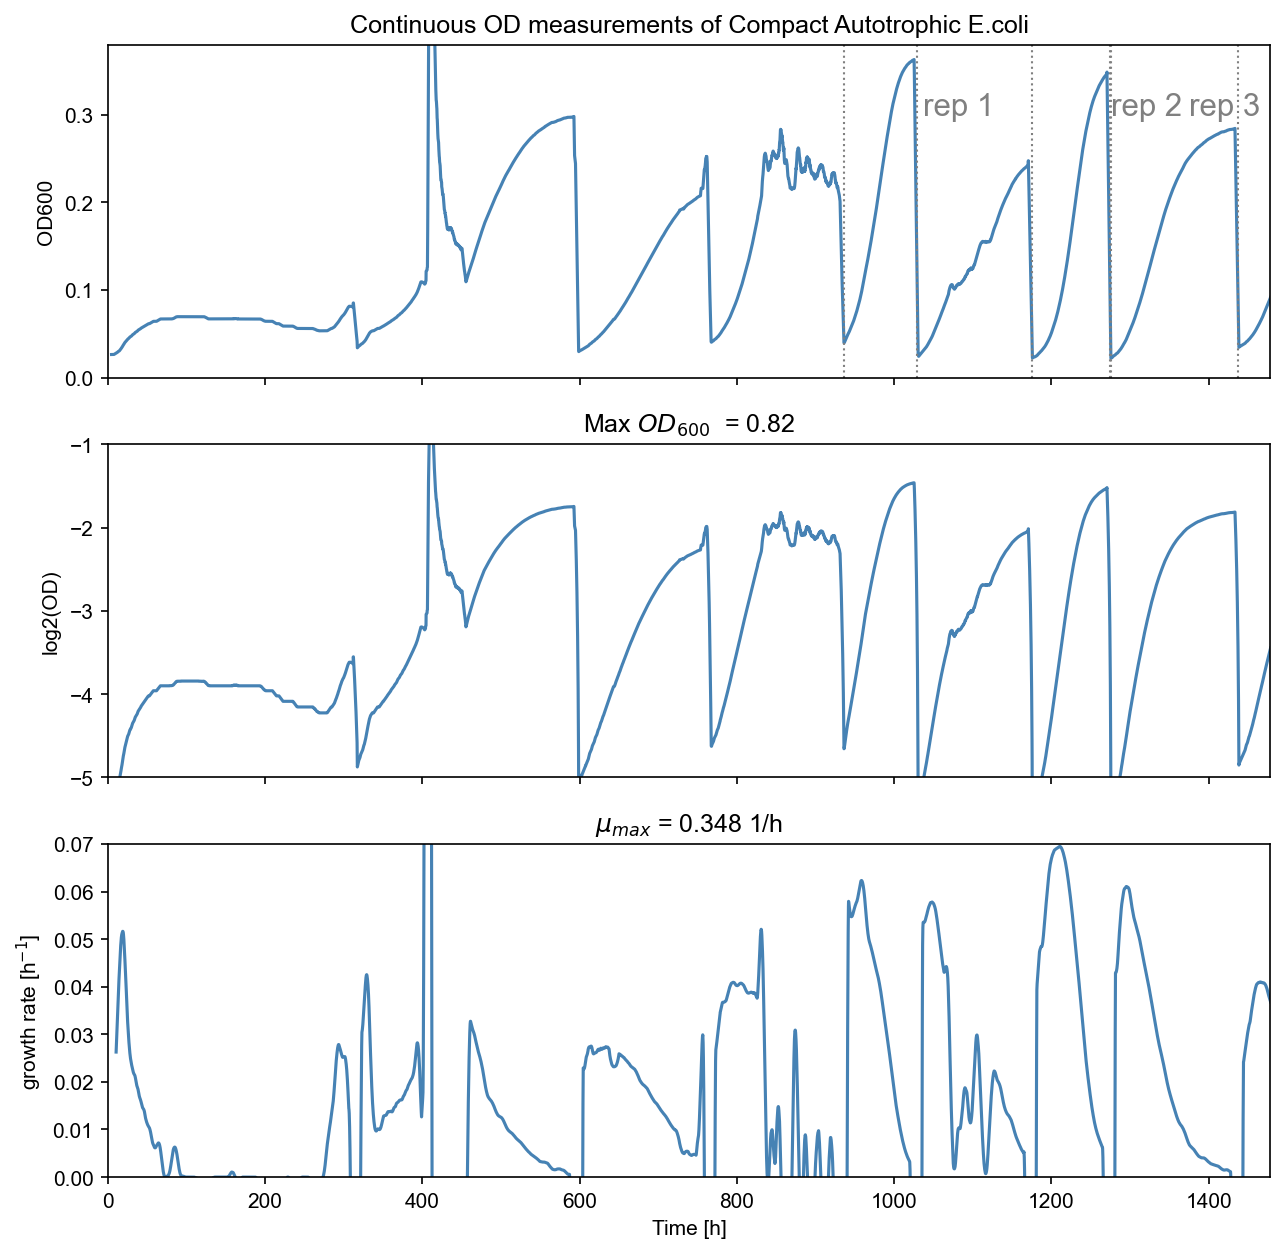

In [9]:
# plotting Compact strain (panel A)
strain, rep = 'Compact', 'All'
figA1 = find_max_growth_rate(
    file_name = orig_file1,
    OD_column = "ODAU3.PV []",
    title = f"Continuous OD measurements of {strain} Autotrophic E.coli",
    strain = strain,
    rep = rep,
    color = "steelblue",
    start = 0,
    end = 'NA'
)
figA1.savefig(f'{dest_file}{strain}-{rep}.svg')

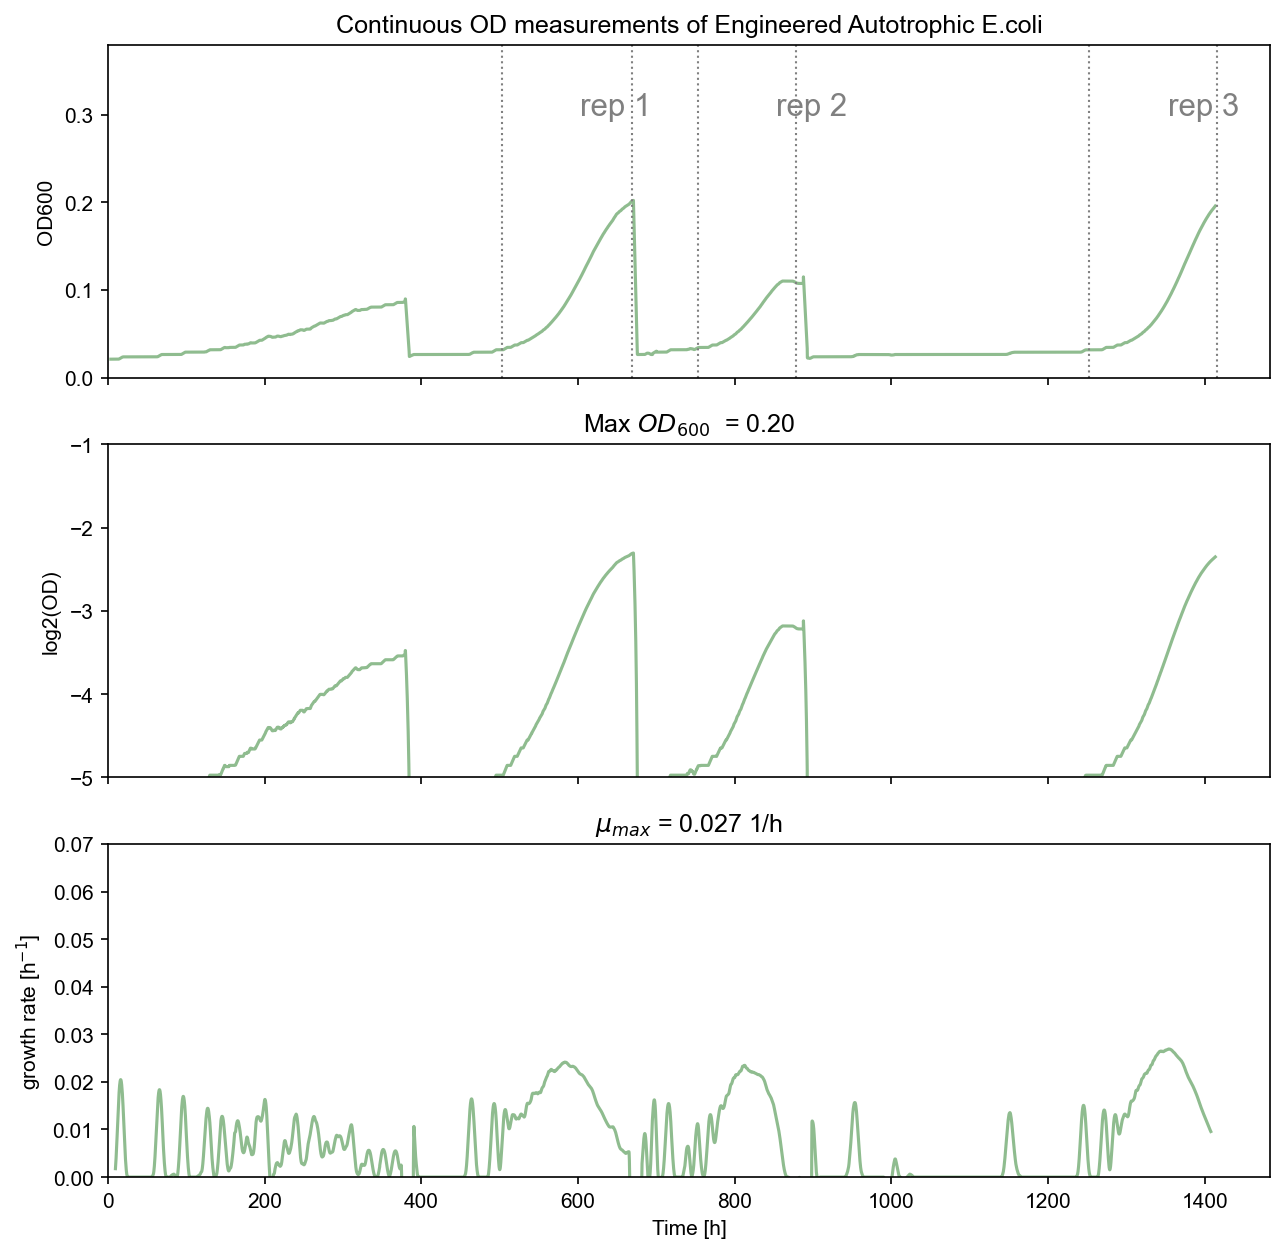

In [11]:
# plotting Engineered strain (panel A)
strain, rep = 'Engineered', 'All'
figA2 = find_max_growth_rate(
    file_name = orig_file2,
    OD_column = "ODAU1.PV []",
    title = f"Continuous OD measurements of {strain} Autotrophic E.coli",
    strain = strain,
    rep = rep,
    color = "darkseagreen",
    start = 0,
    end = 'NA',
)
figA2.savefig(f'{dest_file}{strain}-{rep}.svg')

### Plotting panel B

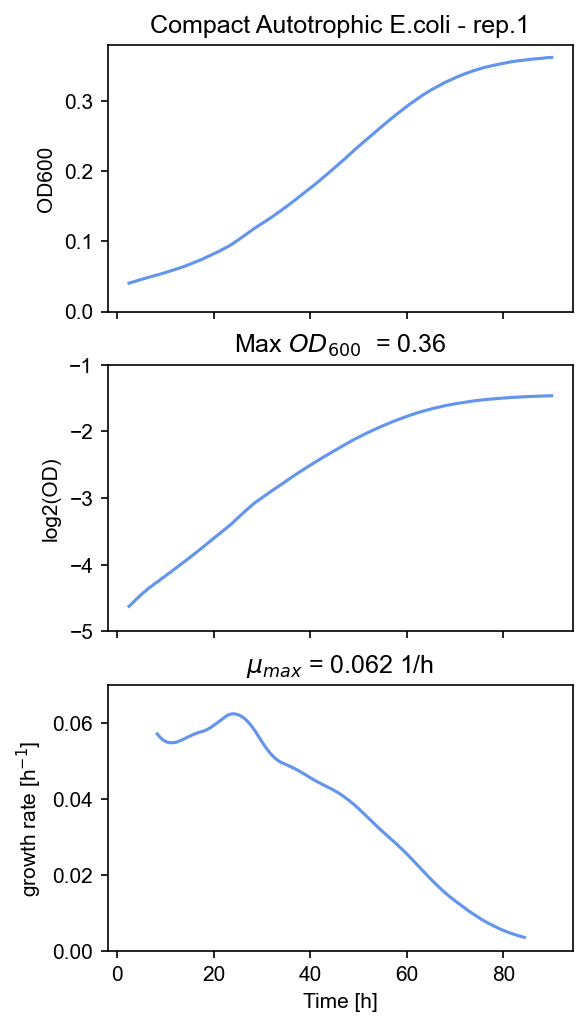

In [12]:
# plotting Compact strain rep 1 (panel B)
strain, rep = 'Compact', 'rep.1'
figB1 = find_max_growth_rate(
    file_name = orig_file1,
    OD_column = "ODAU3.PV []",
    title = f"{strain} Autotrophic E.coli - {rep}",
    strain = strain,
    rep = rep,
    color = "cornflowerblue",
    start = 5596,
    end = 6150
)
figB1.savefig(f'{dest_file}{strain}-{rep}.svg')

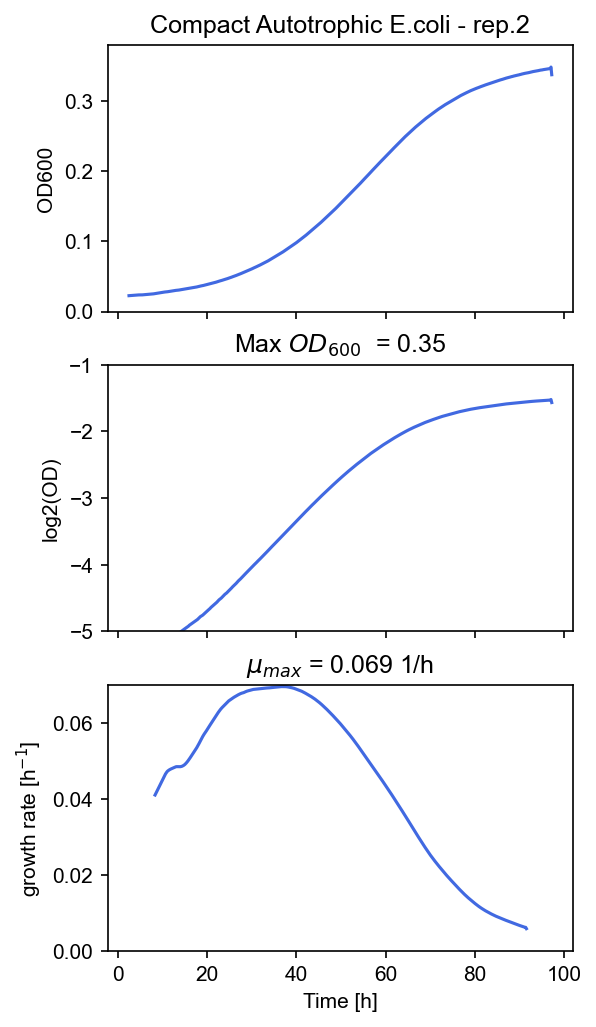

In [13]:
# plotting Compact strain rep 2 (panel B)
strain, rep = 'Compact', 'rep.2'
figB2 = find_max_growth_rate(
    file_name = orig_file1,
    OD_column = "ODAU3.PV []",
    title = f"{strain} Autotrophic E.coli - {rep}",
    strain = strain,
    rep = rep,
    color = "royalblue",
    start = 7032,
    end = 7629,
)
figB2.savefig(f'{dest_file}{strain}-{rep}.svg')

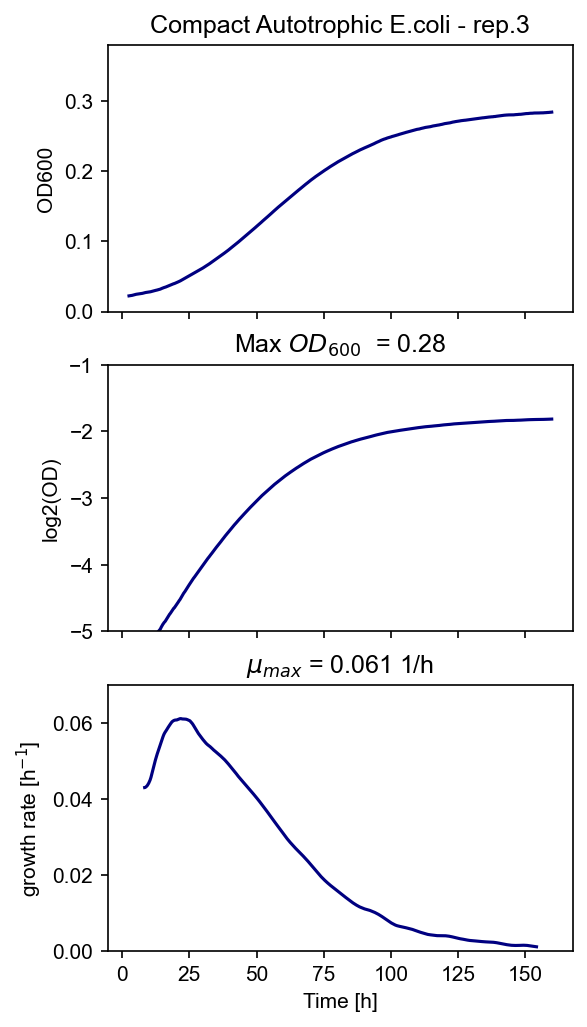

In [15]:
# plotting Compact strain rep 3 (panel B)
strain, rep = 'Compact', 'rep.3'
figB3 = find_max_growth_rate(
    file_name = orig_file1,
    OD_column = "ODAU3.PV []",
    title = f"{strain} Autotrophic E.coli - {rep}",
    strain = strain,
    rep = rep,
    color = "navy",
    start = 7632,
    end = 8605
)
figB3.savefig(f'{dest_file}{strain}-{rep}.svg')

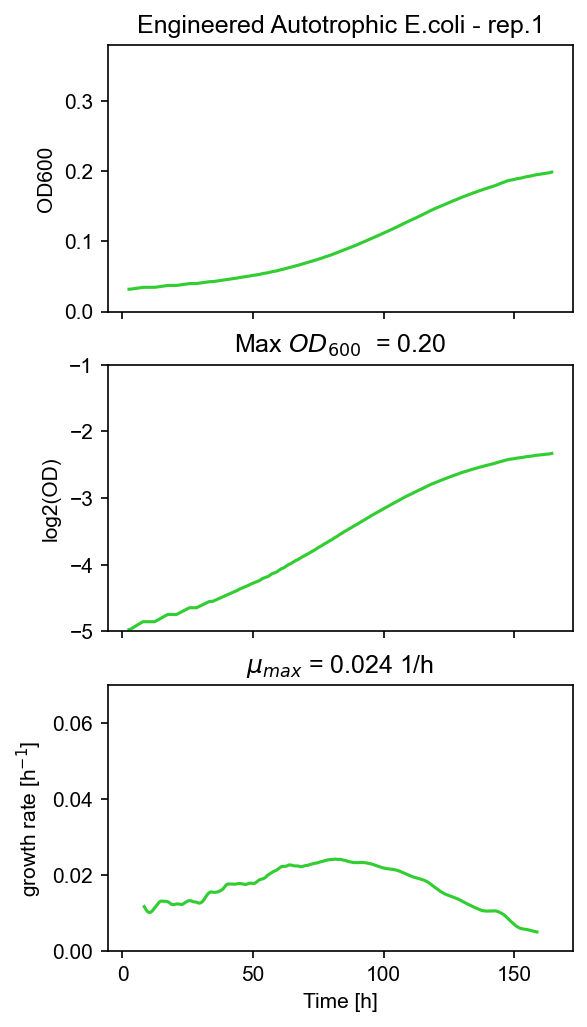

In [20]:
# plotting Engineered strain rep 1 (panel B)
strain, rep = 'Engineered', 'rep.1'
figB4 = find_max_growth_rate(
    file_name = orig_file2,
    OD_column = "ODAU1.PV []",
    title = f"{strain} Autotrophic E.coli - {rep}",
    strain = strain,
    rep = rep,
    color = "limegreen",
    start = 3000,
    end = 4000
)
figB4.savefig(f'{dest_file}{strain}-{rep}.svg')

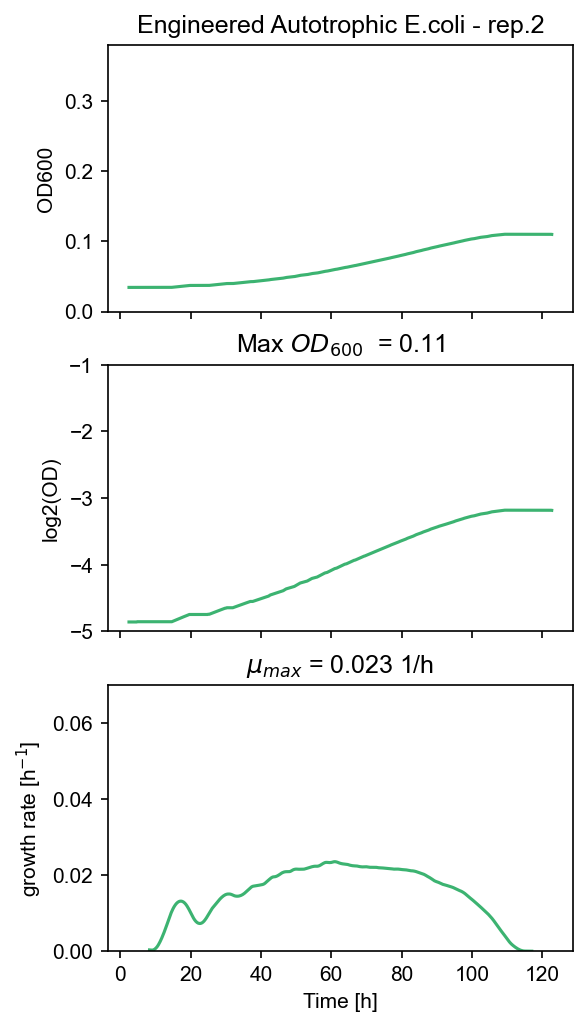

In [17]:
# plotting Engineered strain rep 2 (panel B)
strain, rep = 'Engineered', 'rep.2'
figB5 = find_max_growth_rate(
    file_name = orig_file2,
    OD_column = "ODAU1.PV []",
    title = f"{strain} Autotrophic E.coli - {rep}",
    strain = strain,
    rep = rep,
    color = "mediumseagreen",
    start = 4500,
    end = 5250,
)
figB5.savefig(f'{dest_file}{strain}-{rep}.svg')

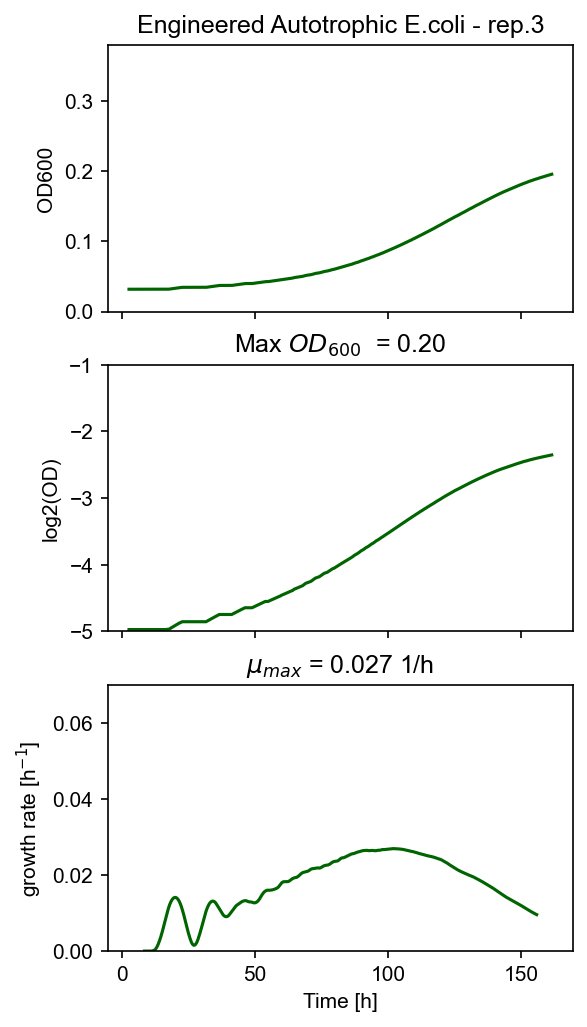

In [18]:
# plotting Engineered strain rep 3 (panel B)
strain, rep = 'Engineered', 'rep.3'
figB6 = find_max_growth_rate(
    file_name = orig_file2,
    OD_column = "ODAU1.PV []",
    title = f"{strain} Autotrophic E.coli - {rep}",
    strain = strain,
    rep = rep,
    color = "darkgreen",
    start = 7500,
    end = 'NA',
)
figB6.savefig(f'{dest_file}{strain}-{rep}.svg')

### Plotting panel C

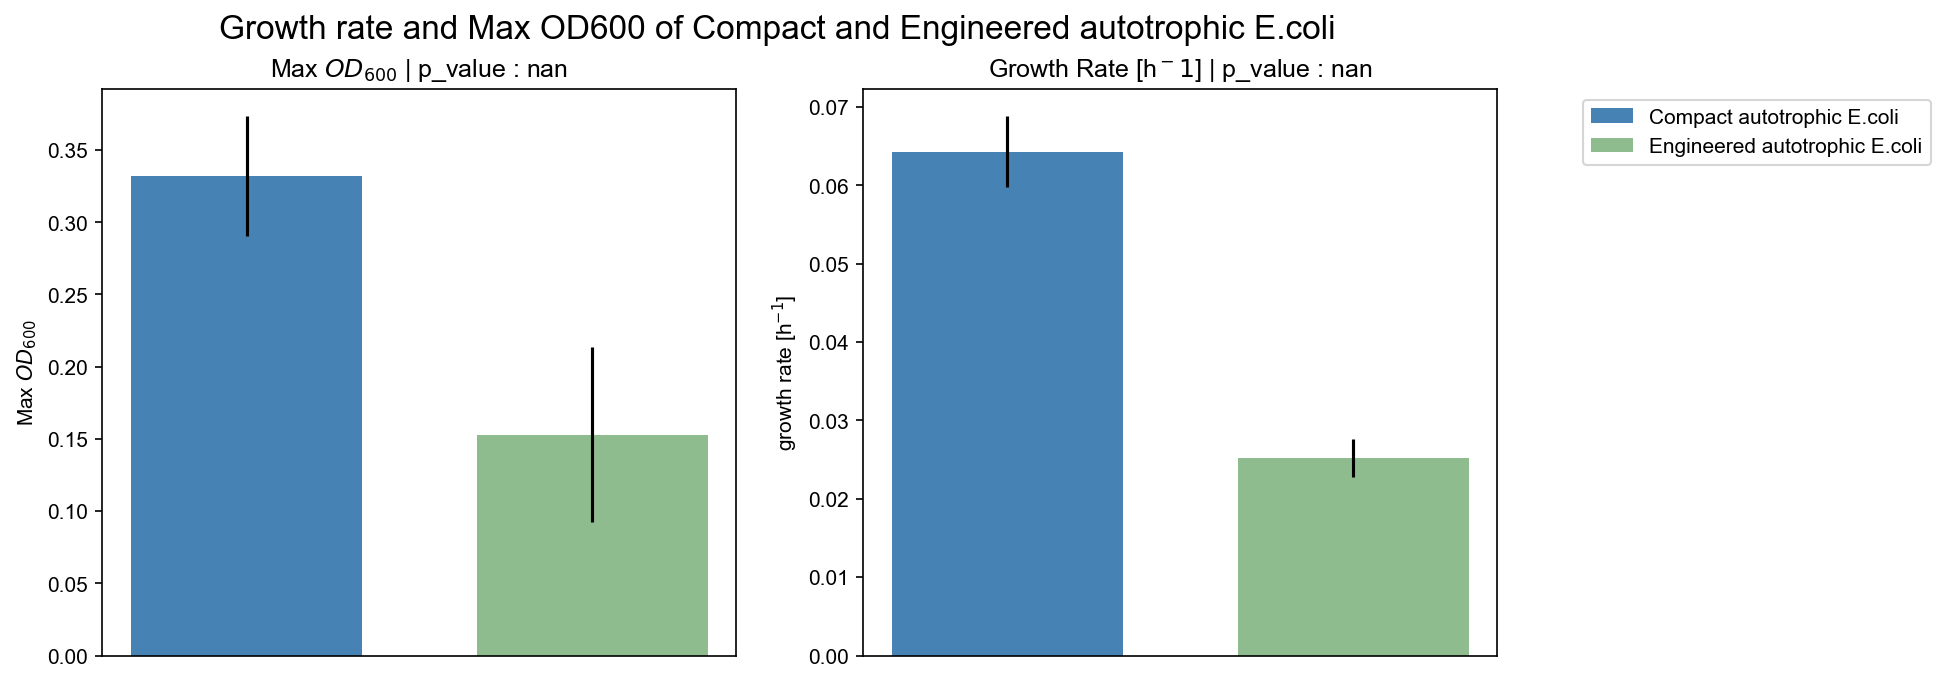

In [19]:
#plotting growth parameters as barplots (panel C)

compact_GR = max_GR['Compact'].drop(index='All')
Engineered_GR = max_GR['Engineered'].drop(index='All')
compact_OD = max_OD['Compact'].drop(index='All')
Engineered_OD = max_OD['Engineered'].drop(index='All')

t_statistic_GR, p_value_GR = stats.ttest_ind(compact_GR, Engineered_GR)
t_statistic_OD, p_value_OD = stats.ttest_ind(compact_OD, Engineered_OD)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
fig.suptitle('Growth rate and Max OD600 of Compact and Engineered autotrophic E.coli', fontsize=16)
axs[0].bar(0, compact_OD.mean(), color = 'steelblue', width = 0.1, yerr=compact_OD.std())
axs[0].bar(0.15, Engineered_OD.mean(), color = 'darkseagreen', width = 0.1, yerr=Engineered_OD.std())
axs[0].set_ylabel(f'Max $OD_{{600}}$')
axs[0].set_xticks([])
# axs[0].set_title(f'p_value : {p_value_OD:.4f}')
axs[0].set_title(f'Max $OD_{{600}}$ | p_value : {p_value_OD:.4f}')
axs[1].bar(0, compact_GR.mean(), color = 'steelblue', width = 0.1, yerr=compact_GR.std())
axs[1].bar(0.15, Engineered_GR.mean(), color = 'darkseagreen', width = 0.1, yerr=Engineered_GR.std())
axs[1].set_ylabel('growth rate [h$^{-1}$]')
axs[1].legend(labels=['Compact autotrophic E.coli', 'Engineered autotrophic E.coli'],bbox_to_anchor=(1.7, 1), frameon=True)
axs[1].set_xticks([])
# axs[1].set_title(f'p_value : {p_value_GR:.4f}')
axs[1].set_title(f'Growth Rate [h$^{-1}$] | p_value : {p_value_GR:.4f}')

plt.savefig(f'{dest_file}Comp_vs_Eng_barplots.svg')